In [4]:
# Run: python3 image.py --image images/image10.jpg
import cv2
import time 
import numpy as np
import argparse
import matplotlib.pyplot as plt

import folium
import geopy
from geopy.geocoders import Nominatim


from flask import Flask, render_template, request 
import plotly.express as px
from plotly.io import to_html
from plotly.subplots import make_subplots
import pandas as pd
import json
import plotly.graph_objects as go
from joblib import load
import numpy as np
from sklearn.preprocessing import QuantileTransformer



In [5]:
# Define class and color of object
classes = [
    "Bus",
    "XeKhach",
    "Bike",
    "Car",
    "Truck",
    "XeBaGac",
    "XeChuyenDung",
    "XeDap",
    "XeContainer"
]

colors = {
    "Bus":(255,255,0),
    "XeKhach":(255,0,255),
    "Bike":(0,255,255),
    "Car":(0,0,255),
    "Truck":(0,255,0),
    "XeBaGac":(255,0,0),
    "XeChuyenDung":(125,125,0),
    "XeDap":(125,0,125),
    "XeContainer":(0,125,125)
}

In [8]:
# Load yolov3-tiny weight and config of dataset Vietnam's traffic
weightsPath = './yolov3.weights'
configPath = './yolov3.cfg'
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Get class object in model
layer_names = net.getLayerNames()
# output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

In [9]:
# Load the image
pt = "./CameraHandler.jpeg"
image = cv2.imread(pt)

In [10]:
# Get dimension of image
height,width = image.shape[:2]

# Detect object
start_time=time.time()
blob = cv2.dnn.blobFromImage(image, 0.00392, (416,416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)
end=time.time()

class_ids = []
confidences = []
boxes = []
# extract output 
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.25:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
object_count = {}
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color=colors[label]
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 1)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        cv2.putText(image, label, (x, y), font, 0.5, color, 1)
    
        # Counting the objects
        if label in object_count:
            object_count[label] += 1
        else:
            object_count[label] = 1
        
print("Detected objects:", object_count)

Detected objects: {'Car': 3, 'Bike': 4}


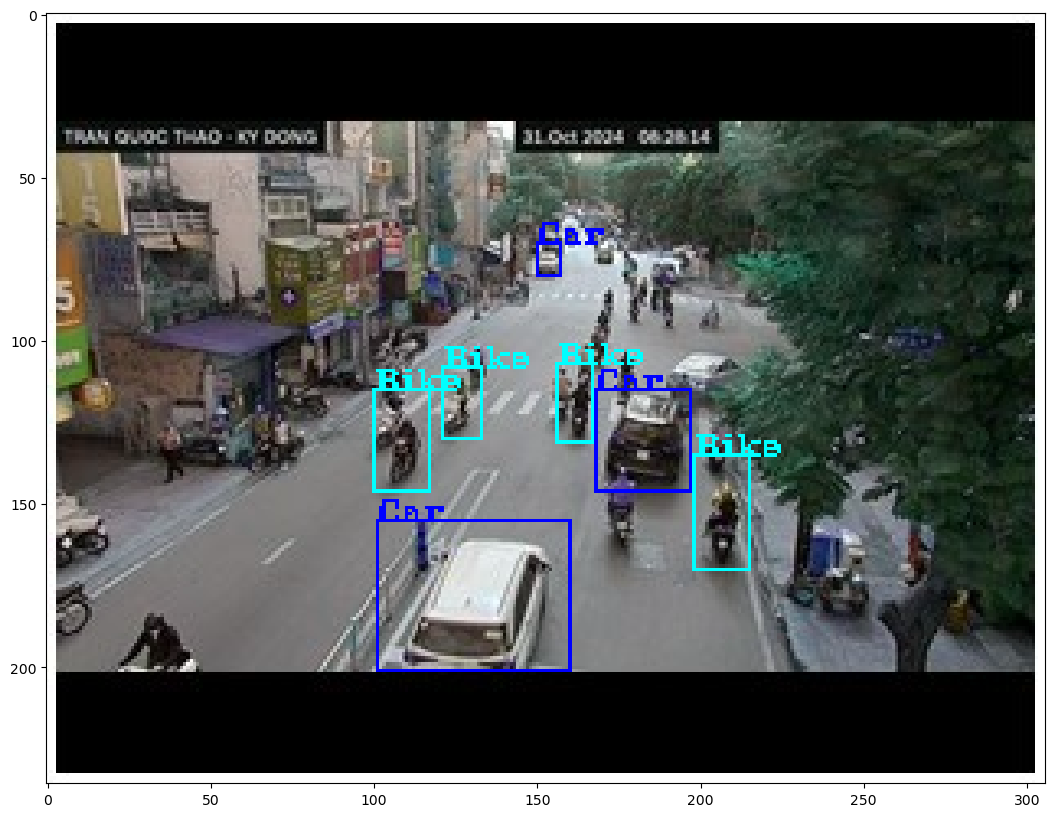

In [11]:
# Show the image 
plt.figure(figsize =( 14, 10))
plt.imshow(image)